In [1]:
from ema_workbench import Scenario, Policy, MultiprocessingEvaluator, ema_logging, load_results, save_results
from ema_workbench.analysis import prim
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework.evaluators import BaseEvaluator

from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ema_workbench.analysis import parcoords
import seaborn as sns
import random
from sklearn import preprocessing

In [2]:
ACTORNAME = "Deventer"
dike_model, planning_steps = get_model_for_problem_formulation(ACTORNAME)
outcomekeys = [outcome.name for outcome in dike_model.outcomes]

# Scenario selection

In [3]:
ACTOR = "genscen_Deventer_50000_12-06-2021-02-25-33.tar.gz"
experiments, outcomes = load_results("data/generated/" + ACTOR)
outcomes_df = pd.DataFrame(outcomes)

In [4]:
outcomes_df.columns.values.tolist()

['Deventer Expected Annual Damage',
 'Deventer Expected Number of Deaths',
 'Deventer Total Costs']

In [5]:
DAMAGE = outcomes_df.columns[0]
DEATHS = outcomes_df.columns[1]
COSTS = outcomes_df.columns[2]

We are interested in the correlation between Deaths and Damage

In [6]:
outcomes_df[DAMAGE].corr(outcomes_df[DEATHS])

0.9838756259821946

So the correlation is INSANE

In [7]:
results = pd.concat([experiments, outcomes_df], axis=1)

In [8]:
uncertainties =list(dike_model.uncertainties._data.keys())

In [9]:
print(outcomes_df.idxmax())
print(outcomes_df.idxmin())

Deventer Expected Annual Damage       18398
Deventer Expected Number of Deaths    16362
Deventer Total Costs                      0
dtype: int64
Deventer Expected Annual Damage       0
Deventer Expected Number of Deaths    0
Deventer Total Costs                  0
dtype: int64


In [10]:
middle_damage_df = results.loc[(results[DAMAGE] > np.percentile(a=outcomes[DAMAGE], q=15)) & (results[DAMAGE] <= np.percentile(a=outcomes[DAMAGE], q=35))]
middle_deaths_df = results.loc[(results[DEATHS] > np.percentile(a=outcomes[DEATHS], q=15)) & (results[DEATHS] <= np.percentile(a=outcomes[DEATHS], q=35))]
twentyfive = random.choice(list(set(middle_damage_df["scenario"].tolist()) & set(middle_deaths_df["scenario"].tolist())))

Apparently, at the lower end of the spectrum ($20>n\leq 30$), there is not a large overlap in deaths and damages

In [11]:
middle_damage_df = results.loc[(results[DAMAGE] > np.percentile(a=outcomes[DAMAGE], q=48)) & (results[DAMAGE] <= np.percentile(a=outcomes[DAMAGE], q=52))]
middle_deaths_df = results.loc[(results[DEATHS] > np.percentile(a=outcomes[DEATHS], q=48)) & (results[DEATHS] <= np.percentile(a=outcomes[DEATHS], q=52))]
fifty = random.choice(list(set(middle_damage_df["scenario"].tolist()) & set(middle_deaths_df["scenario"].tolist())))

In [12]:
middle_damage_df = results.loc[(results[DAMAGE] > np.percentile(a=outcomes[DAMAGE], q=73)) & (results[DAMAGE] <= np.percentile(a=outcomes[DAMAGE], q=77))]
middle_deaths_df = results.loc[(results[DEATHS] > np.percentile(a=outcomes[DEATHS], q=73)) & (results[DEATHS] <= np.percentile(a=outcomes[DEATHS], q=77))]
seventyfive = random.choice(list(set(middle_damage_df["scenario"].tolist()) & set(middle_deaths_df["scenario"].tolist())))

In [13]:
outcomes_df.loc[outcomes_df[DAMAGE] == outcomes_df.max()[0]]

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs
18398,1.640767e+09,1.056804,0.0


In [14]:
min_max_scaler = preprocessing.MinMaxScaler()
damage_scaled = min_max_scaler.fit_transform(pd.DataFrame(outcomes[DAMAGE]).values)
deaths_scaled = min_max_scaler.fit_transform(pd.DataFrame(outcomes[DEATHS]).values)
scaled = (damage_scaled + deaths_scaled)/2

In [15]:
outcomes_df["Scaled"] = scaled
SCALED = 'Scaled'

In [16]:
outcomes_df.sort_values(by="Scaled", ascending=False).head(1).index[0]

16362

Observation: Deventer more people die absolute worst
explanation: more densely populated

In [17]:
idx = [outcomes_df.idxmin()[DAMAGE], twentyfive, fifty, seventyfive, outcomes_df.idxmax()[DEATHS], outcomes_df.idxmax()[DAMAGE]]

In [18]:
idx

[0, 13764, 32273, 27089, 16362, 18398]

In [19]:
cases = {0: "best", 1: "low", 2: "middle", 3: "high", 4: "absolute worst", 5: "worst damage"}

In [20]:
selected = results.iloc[idx]

In [21]:
selected = selected.loc[:,  uncertainties]

In [22]:
scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

In [23]:
outcomes_df.describe()

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths,Deventer Total Costs,Scaled
count,5.000000e+04,50000.000000,50000.0,50000.000000
mean,1.811865e+08,0.165814,0.0,0.130268
std,2.724127e+08,0.241198,0.0,0.191427
min,0.000000e+00,0.000000,0.0,0.000000
25%,0.000000e+00,0.000000,0.0,0.000000
50%,5.698603e+07,0.055319,0.0,0.042527
75%,2.341050e+08,0.218497,0.0,0.169648
max,1.640767e+09,1.104637,0.0,0.980246


# Optimisation

In [24]:
hypervolumemin = [0,0,0]
hypervolumemax = outcomes_df[outcomekeys].max(axis=0).values.tolist()

In [25]:
hypervolumemax[2] = 1.15e9

In [26]:
ema_logging.log_to_stderr(ema_logging.INFO)

nfe = 1000 + 1000

def optimize(scenario, nfe, model, converge_metrics, epsilons):


    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                     convergence=convergence_metrics,
                                     epsilons=epsilons,
                                     reference=scenario, convergence_freq=200)
    return results, convergence

results = []
for scenario in scenarios:
    convergence_metrics = [HyperVolume(minimum=hypervolumemin, maximum=hypervolumemax),
                           EpsilonProgress()]
    epsilons = [1e4, 0.01, 1e3]
    
    
    
    results.append(optimize(scenario, nfe, dike_model, convergence_metrics, epsilons))


[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/2000 nfe
[MainProcess/INFO] generation 5: 494/2000 nfe
[MainProcess/INFO] generation 10: 987/2000 nfe
[MainProcess/INFO] generation 15: 1468/2000 nfe
[MainProcess/INFO] generation 20: 1945/2000 nfe
[MainProcess/INFO] optimization completed, found 1 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/2000 nfe
[MainProcess/INFO] generation 5: 496/2000 nfe
[MainProcess/INFO] generation 10: 988/2000 nfe
[MainProcess/INFO] generation 15: 1484/2000 nfe
[MainProcess/INFO] generation 20: 1981/2000 nfe
[MainProcess/INFO] optimization completed, found 1 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/2000 nfe
[MainProcess/INFO] generation 5: 494/2000 nfe
[MainProcess/INFO] generation 10: 984/2000 nfe
[MainProcess/INFO] generation 15: 1476/2000 nfe
[MainProcess/INFO] generation 20: 1964/2000 nfe
[MainProces

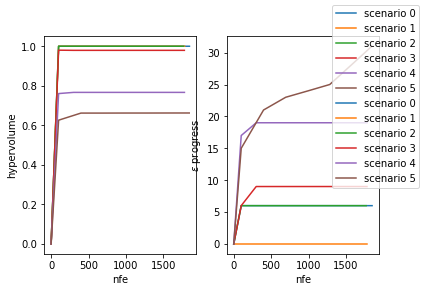

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=2,sharex=True)
for i, (_, convergence) in enumerate(results):
    ax1.plot(convergence.nfe, convergence.hypervolume, label=f'scenario {i}')
    ax2.plot(convergence.nfe, convergence.epsilon_progress, label=f'scenario {i}')

ax1.set_ylabel('hypervolume')
ax1.set_xlabel('nfe')
ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')
fig.legend()
plt.show()

We have tried the optimisation above with multiple values for nfe, epsilon and hypervolume. Because Deventer only has limited levers available, and only their own RfR project increases their costs, the pareto front is relatively small, and there are very little policy suggestions. We found that changing the epsilon value for costs has the most impact on the amount of policy results (logically).

The NFE is small, as there are very little levers, and only the RFR affects the costs, therefore it converges rather quickly.

# Saving

In [28]:
for i, (result, convergence) in enumerate(results):
    result.to_csv("data/optimisation/" + ACTORNAME + "/results_" + cases[i] +".csv", index=False)
    convergence.to_csv("data/optimisation/" + ACTORNAME + "/convergence_" + cases[i] +".csv", index=False)

In [29]:
selected.to_csv("data/optimisation/" + ACTORNAME + "/selected.csv", index=False)

# Re-evaluate under deep uncertainty

In [30]:
n_scenarios = 1000

In [31]:
levers = [lever.name for lever in dike_model.levers]

In [32]:
policies = []
for i, (result, _) in enumerate(results):
    result = result.loc[:, levers]
    for j, row in result.iterrows():
        policy = Policy(f'scenario {cases[i]} option {j}', **row.to_dict())
        policies.append(policy)

In [33]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    reevaluation_results = evaluator.perform_experiments(n_scenarios, policies=policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 13 policies * 1 model(s) = 13000 experiments
[MainProcess/INFO] 1300 cases completed
[MainProcess/INFO] 2600 cases completed
[MainProcess/INFO] 3900 cases completed
[MainProcess/INFO] 5200 cases completed
[MainProcess/INFO] 6500 cases completed
[MainProcess/INFO] 7800 cases completed
[MainProcess/INFO] 9100 cases completed
[MainProcess/INFO] 10400 cases completed
[MainProcess/INFO] 11700 cases completed
[MainProcess/INFO] 13000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


# Saving

In [34]:
save_results(reevaluation_results, "data/optimisation/du_scen_" + str(n_scenarios) + "_" + ACTORNAME + ".tar.gz")

[MainProcess/INFO] results saved successfully to E:\Onedrive\Documenten\Universiteit\Delft\Q4-2020\Model-based-Decision-making\Assignments\FabiosDecisions\epa1361\final assignment\data\optimisation\du_scen_1000_Deventer.tar.gz
